Example Author: Jacob Chittock-Wood

In [1]:
%matplotlib inline
%gui qt

In [2]:
import sys, os, tempfile
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import qcodes
import qtt
import logging

In [3]:
#Import from qcodes libs
from qcodes import MatPlot, QtPlot
from qcodes.instrument_drivers.Keysight.KeysightAgilent_33XXX import WaveformGenerator_33XXX
from qcodes.instrument_drivers.QDev.QDac import QDac
from qcodes.instrument_drivers.tektronix.Keithley_2600_channels import Keithley_2600

# Import from qtt libs
from qtt.instrument_drivers.gates import VirtualDAC #This will not work unless you've replaced the gates.py file in your library
from qtt.measurements.scans import scanjob_t
#from qtt.instrument_drivers.virtual_instruments import VirtualMeter
#from qtt.simulation.virtual_dot_array import DotModel

from qtt.instrument_drivers.FPGA_ave import FPGA_ave
from qtt.measurements.videomode import VideoMode

# set data directory
datadir = os.path.join(tempfile.mkdtemp(), 'qdata')
qcodes.DataSet.default_io = qcodes.DiskIO(datadir)

## Example 1: QDAC

To use the majority of `qtt` functions you need to define a `qcodes.station` using a function such as `initialize()` below. Some more context is given at: https://github.com/QuTech-Delft/qtt/blob/d90c236af7c05621a7214f5489e39c839c37e2ec/docs/notebooks/measurements/example_station.ipynb )

An important part of this is the defining of `gates`. If you wanted to setup these gates to be used by a DAC, an easy way to go about doing this is by first defining a `gate_map`: 

`gate_map (dict): the map between the names gates and the physical instrument channels`

The format of the `gate_map` to map the gate 'P1' to dac4 of the first instrument and 'B0' to dac3 of the second instrument is:

`{'P1': (0, 4), 'B0': (1, 3)}`

In this sense `dac4` and `dac3` refer to channel 4 on DAC0 & channel 3 on DAC1.

In [4]:
# the gate_map defines the relation between names gates and the DAC channels of physical instruments
# in the VirtualDAC function (n,m), m is used as the channel number and n is the DAC number
gate_map = {'S0': (0,1), 'P1': (0,2), 'P3': (0,3)}

To use this with your specific DAC you will need to modify your `qtt.instrument_drivers.gates.py` file in your python directory (for example for me it's: `C:\Users\Nanouser\miniconda\envs\qcodes\Lib\site-packages\qtt\instrument_drivers`)

Until it is updated in `qtt` I would suggest replacing the current `gates.py` with: https://github.com/QuTech-Delft/qtt/blob/a2e58ed0942801e6883886a77fc7dbc86329f859/qtt/instrument_drivers/gates.py

The `VirtualDAC` class in this file can be used to setup a DAC. The code that needs to be changed in order for it to work with your specific DAC is where it attempts to use a command on the DAC, such as set the voltage (`qtt` obviously doesn't know the function that changes the voltage on your specific DAC!).

In this case changing `gates.py` to work with a QDAC is relatively simple, in line 76: we change: 

`igate = dac%d % gatemap[1]` to `igate = 'ch0%d_v' % gatemap[1]`

Why? Because in the following line: `self._direct_gate_map[gate] = getattr(i, igate)`

This translates to `DAC.dac1` for an instrument input as `DAC`, however if your instrument is the QDAC, there is no parameter `dac1` so we need to change this to a parameter that does exist, i.e. `ch01_v`.

You should check for further uses of `dac%d` and change them accordingly.

Once this is done the QDAC can be setup and used with `qtt` functions. See below:

In [5]:
def initializeQDAC():

    logging.info('my station: initialize')

    # Connect to QDAC
    qdac = QDac('qdac', 'ASRL6::INSTR', update_currents=False)

    # Connect to Keithley
    keithley = Keithley_2600(name='keithley', address='TCPIP0::192.168.15.101::inst0::INSTR')
    
    # Setup dummy keithley
#    keithley = VirtualMeter('keithley', model=None)
#    keithley.add_parameter('keithley_amplitude',
#                           label='Amplitude (pA)'.format('keithley_amplitude'),
#                           get_cmd=partial(getattr(keithley, '_get'), 'amplitude'),
#                          )
    
    logging.info('my station: all drivers have been loaded')

    # Create gates
    gates = VirtualDAC(name='gates', gate_map=gate_map, instruments=[qdac])

    #Creating the experimental station
    station = qcodes.Station(gates, qdac, keithley)

    logging.info('my station: initialization done')   
    return station

In [6]:
stationQDAC = initializeQDAC()

Connected to: Keithley Instruments Inc. 2614B (serial:4321834, firmware:3.2.2) in 0.09s


You can check the output of the QDAC with an oscilloscope. A keithley is also setup if you want to try and measure the output with that. We need to define a measurement instrument to satisfy the 'requirement' of the `scan1D` function.

In [7]:
keithley = stationQDAC.keithley

In [8]:
# Sets up the live plotter
mwindows = qtt.gui.live_plotting.setupMeasurementWindows(stationQDAC, create_parameter_widget=False)
plotQ = mwindows['plotwindow']

In [9]:
scanjob = scanjob_t({'sweepdata': dict({'param': 'S0', 'start': 0.1, 'end': 0.5, 'step': .002, 
                                        'wait_time': 3e-3}), 'minstrument': [keithley.smua.volt]})
data1d = qtt.measurements.scans.scan1D(stationQDAC, scanjob, location=None, verbose=1)

[<qcodes.instrument.parameter.Parameter: volt at 2476291441160>]
scan1D: 0/200: time 0.4
scan1D: 29/200: time 2.0
scan1D: 57/200: time 3.5
scan1D: 86/200: time 5.0
scan1D: 115/200: time 6.5
scan1D: 143/200: time 8.0
scan1D: 172/200: time 9.6


The QDAC should have ramped from 10 mV to 50 mV

## Example 2: Alazar

In `qtt` FPGAs such as the Alazar ATS have a specific class `FPGA_ave` found in `qtt.instrument_drivers` (https://qtt.readthedocs.io/en/latest/_modules/qtt/instrument_drivers/FPGA_ave.html#FPGA_ave.get_idn). To use the FPGA with `qtt` you must connect to it differently, normally one would use:

`alazar = ATSdriver.AlazarTech_ATS9360(name='Alazar')`

with `qtt` I used:

`fpga = FPGA_ave(name='fpga', address='ASRL1::INSTR')`

To provide the same functionality as the Alazar driver, I added several methods to this `FPGA_ave`.
These methods setup the Alazar, the controller and channel. 

In the method `readFPGA` I replaced the:

`DataRead_ch1 = self.get_ch1_data(checkdone=False, buf=True)`

with 

`DataRead_ch1 = self.channel.data.get()`

The wrapper I have written only works for single channel, but using the example code in the qdev wrappers, it could be setup for two channels (https://github.com/qdev-dk/qdev-wrappers/blob/master/examples/Alazar/Qcodes%20example%20with%20Alazar%20ATS9360.ipynb)

In [10]:
def initializeFPGA():

    logging.info('my station: initialize')
    
    # Connect to HP33210A AWG
    awg = WaveformGenerator_33XXX(name='awg', address='TCPIP0::192.168.15.102::inst0::INSTR')
    
    # Create the ATS9360 instrument
    fpga = FPGA_ave(name='fpga', address='ASRL1::INSTR')
    
    logging.info('my station: all drivers have been loaded')

    #Creating the experimental station
    station = qcodes.Station(awg, fpga)

    logging.info('my station: initialization done')   
    return station

In [11]:
station = initializeFPGA()

fpga = station.fpga

Connected to: Agilent Technologies 33210A (serial:MY48000757, firmware:1.02-1.02-26-2) in 0.02s
FPGA internal clock is 50MHz, dividing it by 50, yields samp. freq. is 1000000 Hz


In [12]:
station.awg.ch1.output('ON')
station.awg.ch1.function_type('RAMP')

period = 50.0e-6
station.awg.ch1.frequency(1/period)

In [13]:
fpga.alazar_setup()

In [14]:
fpga.setup_controller()

In [15]:
fpga.set_int_delay(2e-5)
fpga.set_int_time(2e-6)

In [16]:
fpga.setup_channel(channel='A', num_averages=1)

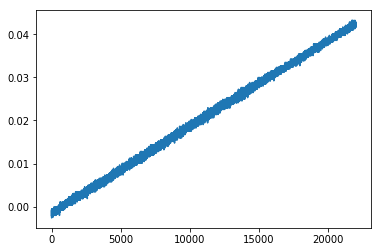

In [17]:
totalpoints, DataRead_ch1, DataRead_ch2 = fpga.readFPGA(ReadDevice=['FPGA_ch1'])

plt.plot(DataRead_ch1)